In [83]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
print(torch.__version__)


2.6.0+cpu


In [3]:
train_mnist_data = MNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)


test_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

In [4]:
train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data, batch_size=32, shuffle=False, num_workers=2
)

Text(0.5, 1.0, 'Image label: 7')

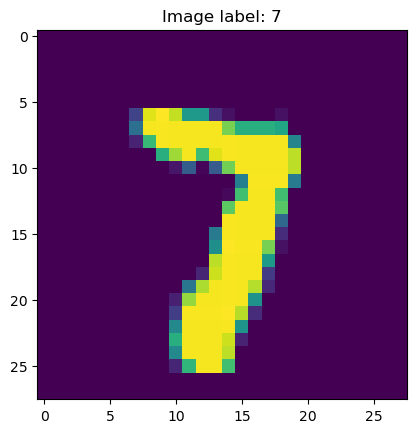

In [5]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

In [6]:
activation = nn.Mish


#Encoder
model = nn.Sequential()
model.add_module('l1_e', nn.Conv2d(1, 4, kernel_size=3, padding=(1, 1), stride=(2, 2)))
model.add_module('activation1', activation())
model.add_module('l2_e', nn.Conv2d(4, 16, kernel_size=3, padding=(1, 1), stride=(2, 2)))
model.add_module('activation2', activation())
model.add_module('l3_e', nn.Conv2d(16, 64, kernel_size=3, padding=(0, 0), stride=(1, 1)))
model.add_module('activation3', activation())
model.add_module('l4_e', nn.Conv2d(64, 256, kernel_size=3, padding=(0, 0), stride=(1, 1)))
model.add_module('activation4', activation())
model.add_module('l5_e', nn.Conv2d(256, 1024, kernel_size=3, padding=(0, 0), stride=(1, 1)))
model.add_module('activation5', activation())


model.add_module('l6_d', nn.ConvTranspose2d(1024, 256, kernel_size=3))
model.add_module('activation6', activation())
model.add_module('l7_d', nn.ConvTranspose2d(256, 64, kernel_size=3))
model.add_module('activation7', activation())
model.add_module('l8_d', nn.ConvTranspose2d(64, 16, kernel_size=3))
model.add_module('activation8', activation())
model.add_module('l9_e', nn.ConvTranspose2d(16, 4, kernel_size=4, padding=(1, 1), stride=(2, 2), dilation=(1, 1)))
model.add_module('activation9', activation())
model.add_module('l10_e', nn.ConvTranspose2d(4, 1, kernel_size=4, padding=(1, 1), stride=(2, 2), dilation=(1, 1)))


# model.add_module('l3', nn.Conv2d(15, 50, kernel_size=3, padding=(1, 1)))

In [7]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 3
loss_func = nn.MSELoss(reduction='mean')

In [8]:
def train_model(model, train_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    input_im = []
    output_im = []
    
    for epoch in tqdm(range(n_epochs)):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        i = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # move data to target device
            ### YOUR CODE HERE

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            # print(X_batch.reshape(-1, 1, 28, 28).shape)
            y_pred = model(X_batch.reshape(-1, 1, 28, 28))
            # print(y_pred.shape)
            # print(y_pred.shape)
            loss = loss_func(y_pred, X_batch.reshape(-1, 1, 28, 28))
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

            if ((epoch == 0) and (i == 0)):
                input_im.append(X_batch.reshape(-1, 1, 28, 28))
                output_im.append(y_pred)

            i += 1
                
        model.train(False) # disable dropout / use averages for batch_norm
            


        train_loss.append(np.mean(ep_train_loss))
        # print(train_loss)
        # val_loss.append(np.mean(ep_val_loss))
        # val_accuracy.append(np.mean(ep_val_accuracy))

    return model, train_loss, input_im, output_im

In [9]:
if False:
    model, train_loss, input_im, output_im = train_model(model, train_data_loader, loss_func, opt, n_epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

In [28]:
class VerboseExecution(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: {output.shape}")
            )

    def forward(self, x):
        return self.model(x)

In [29]:
if False:
    verbose_resnet = VerboseExecution(model)
    print(verbose_resnet(_image))

In [30]:
torch.save(model.state_dict(), 'model_weights_cnn.pth')

Text(0.5, 1.0, 'MSE')

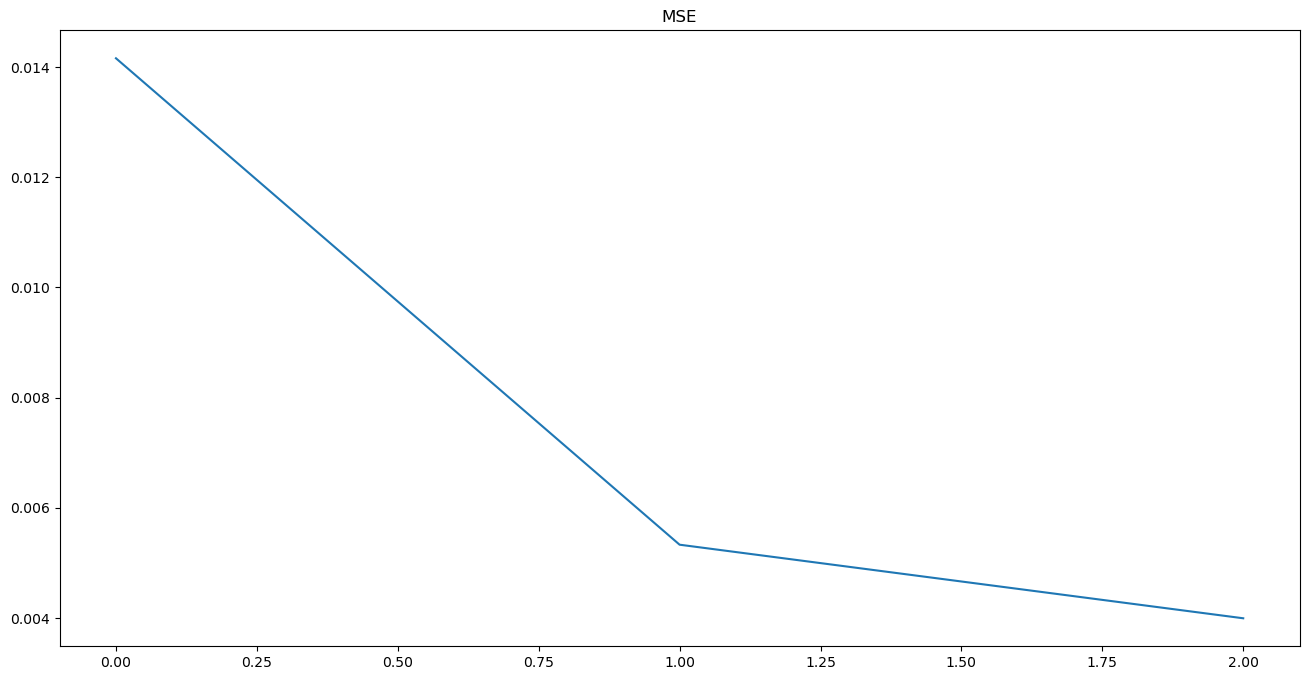

In [31]:
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.plot(train_loss)
ax.set_title("MSE")

1
1
torch.Size([32, 1, 28, 28])


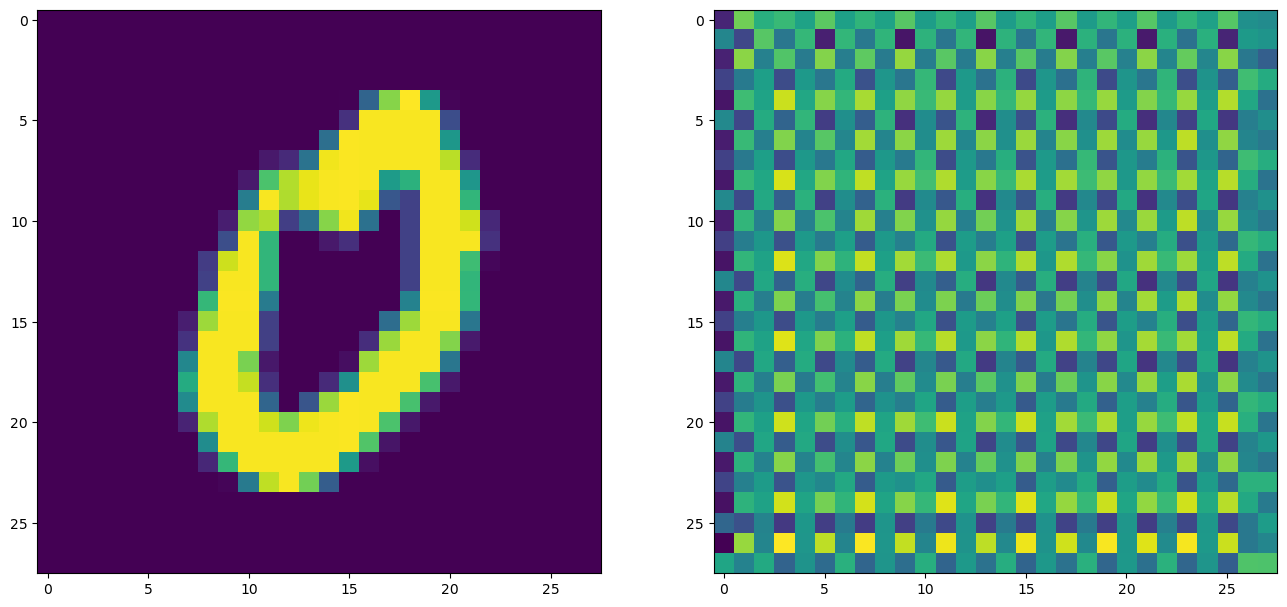

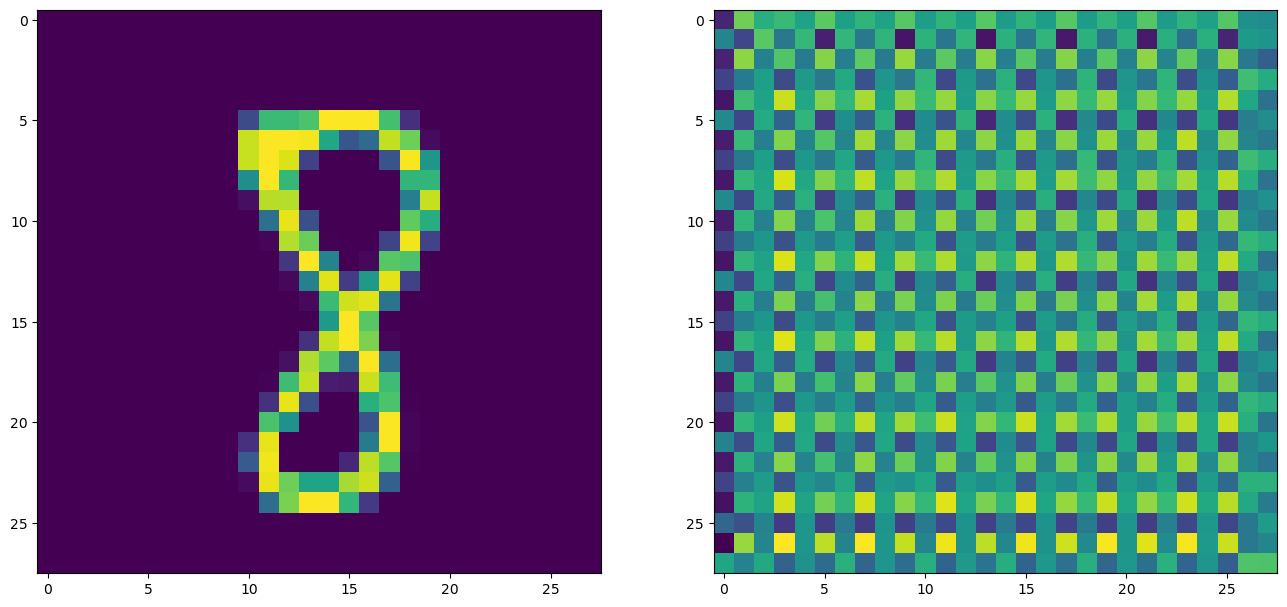

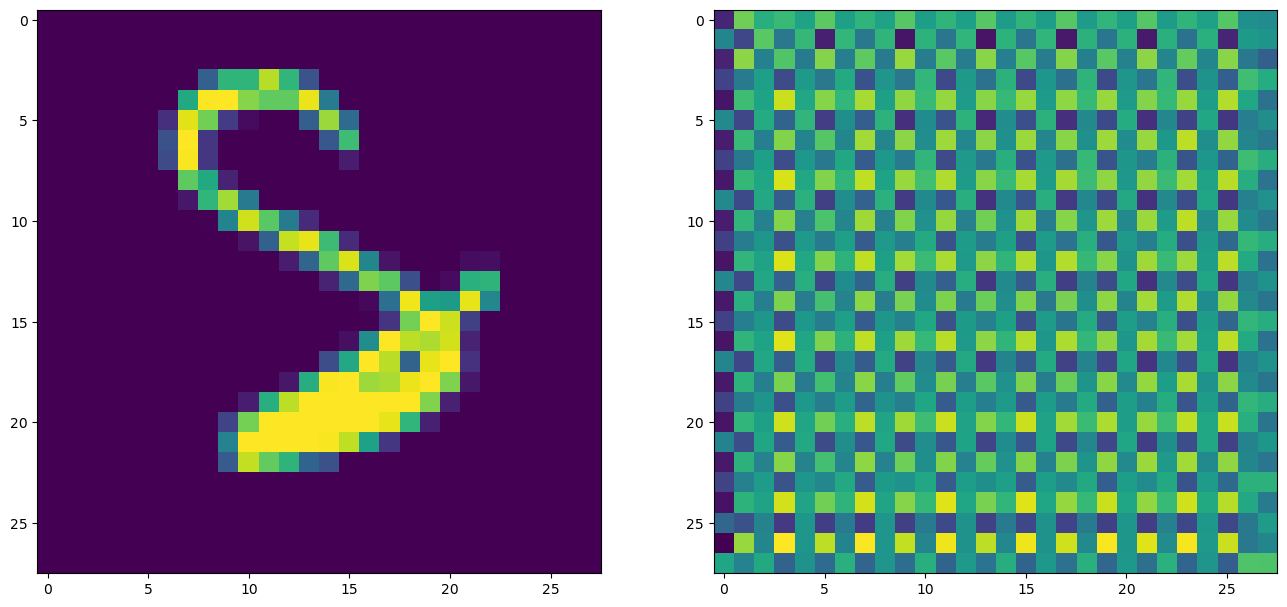

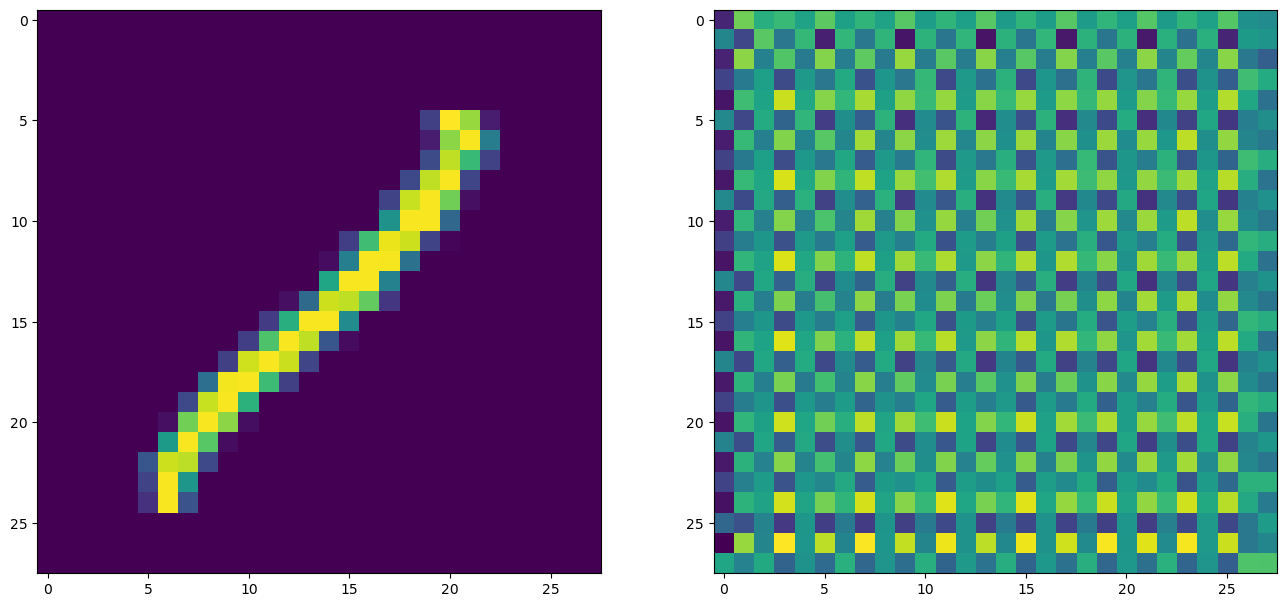

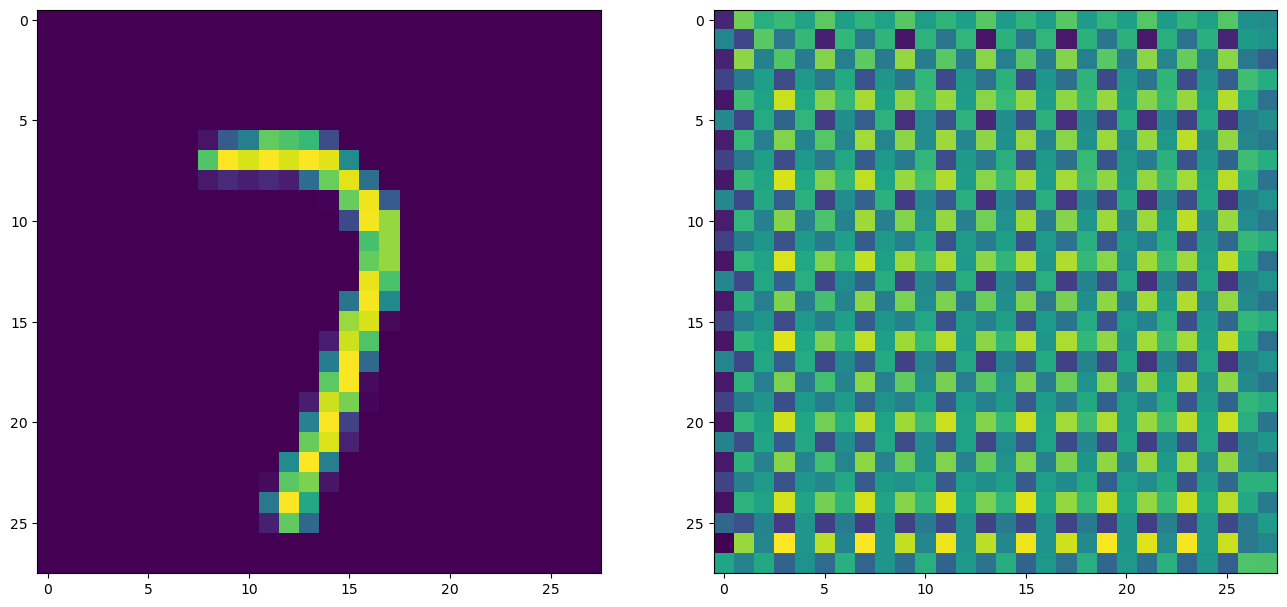

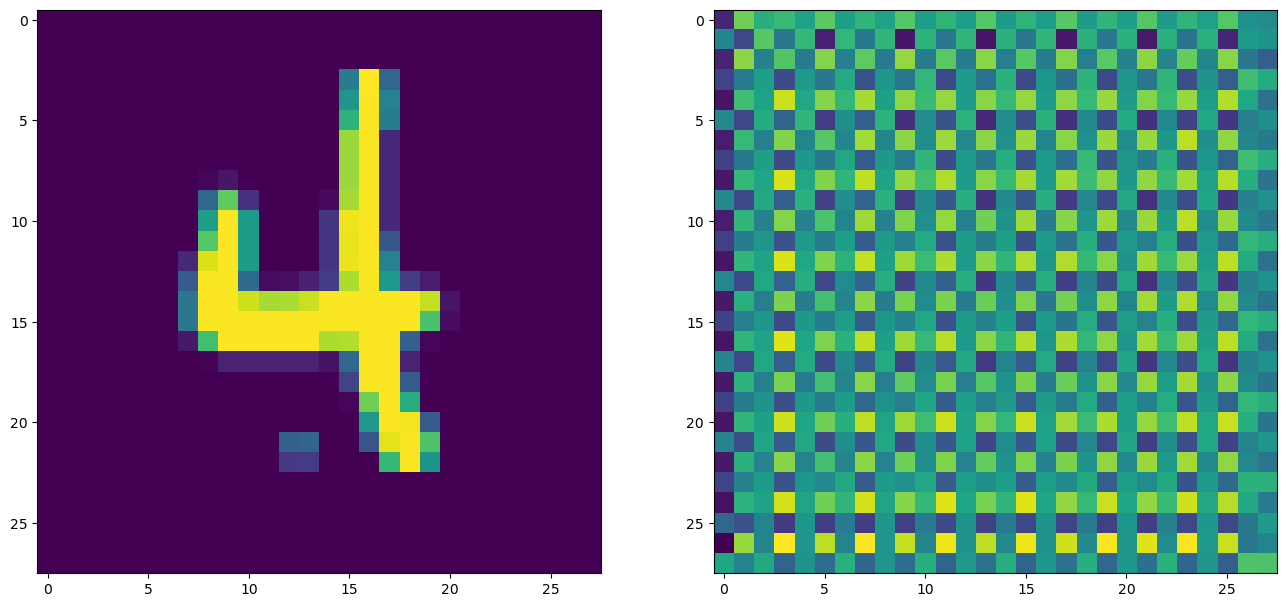

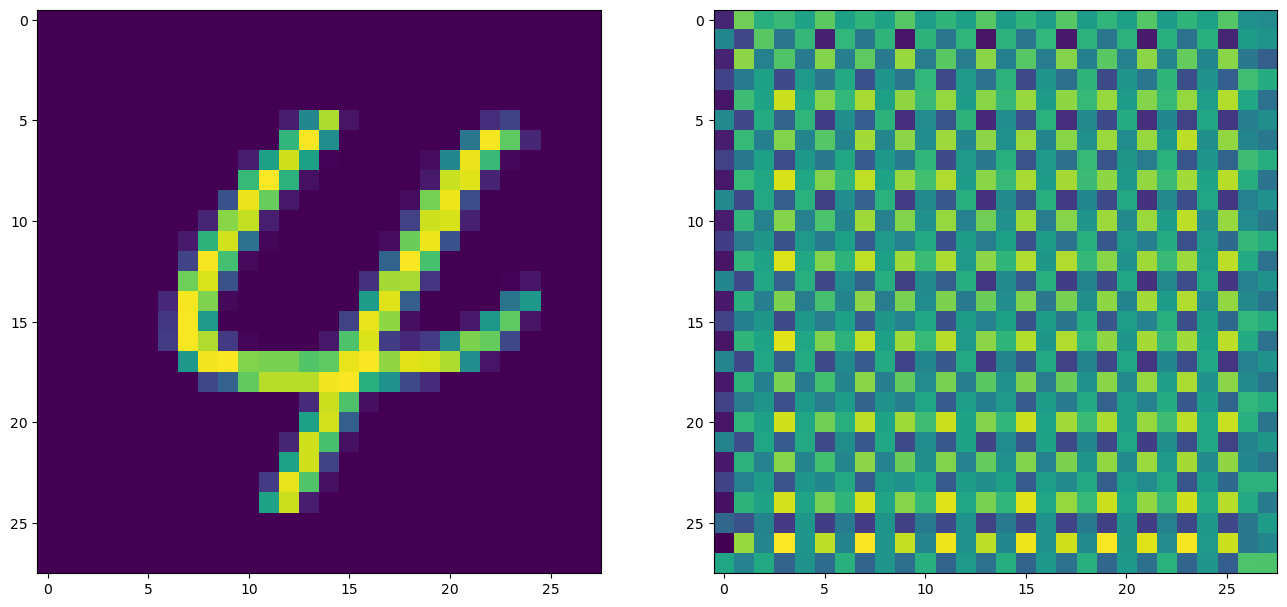

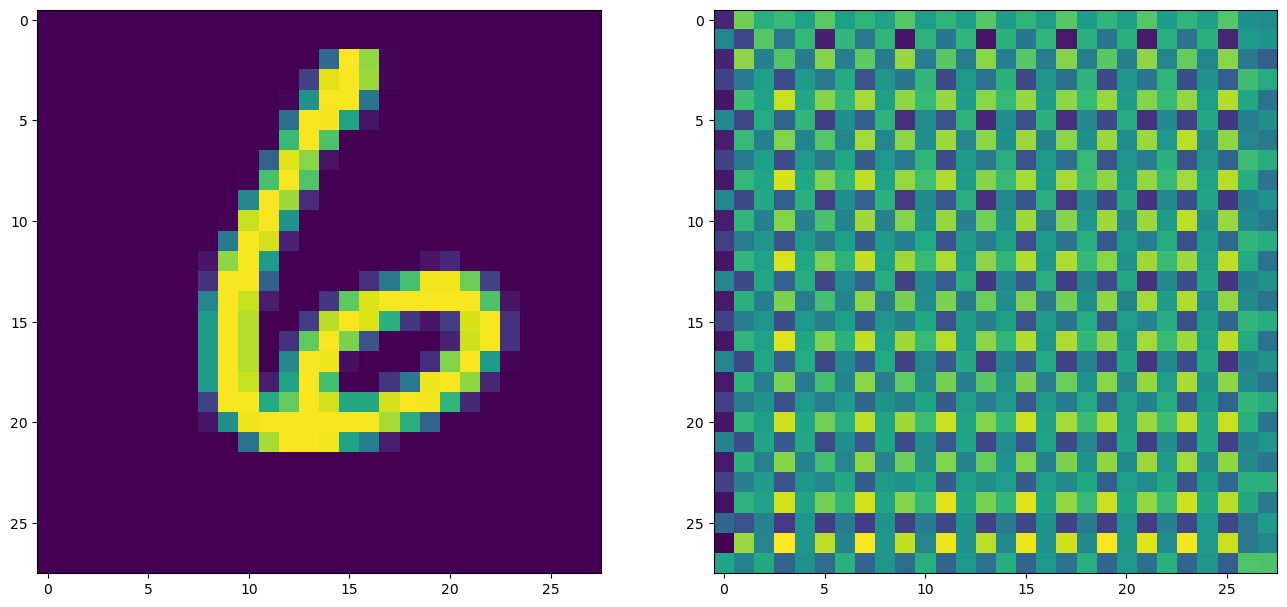

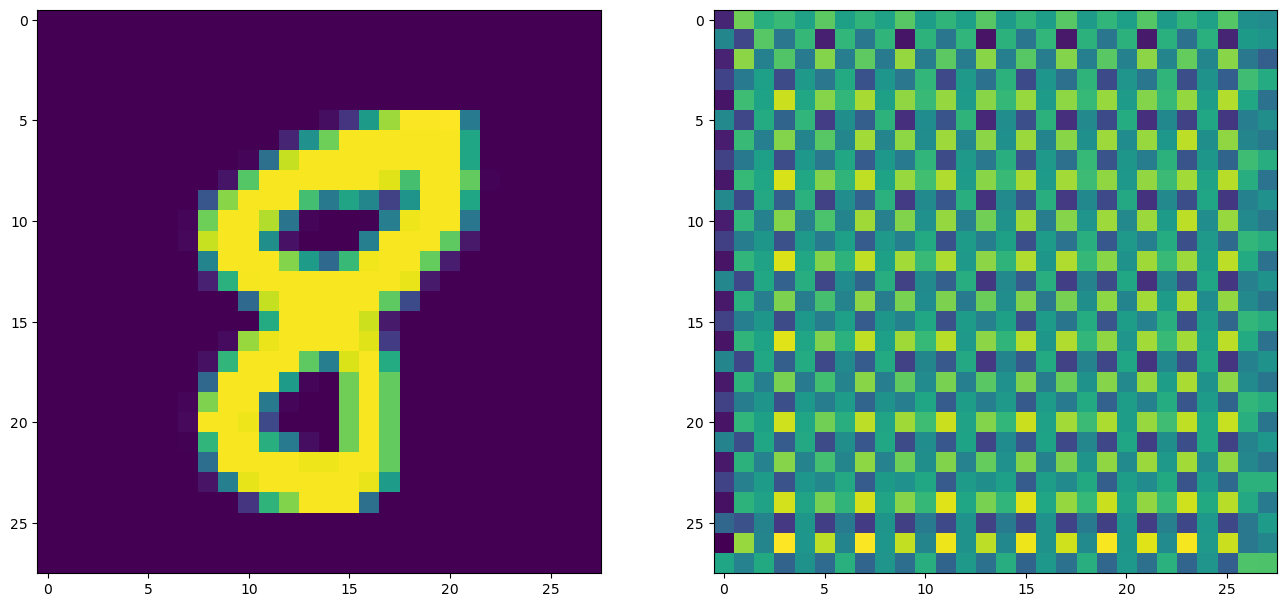

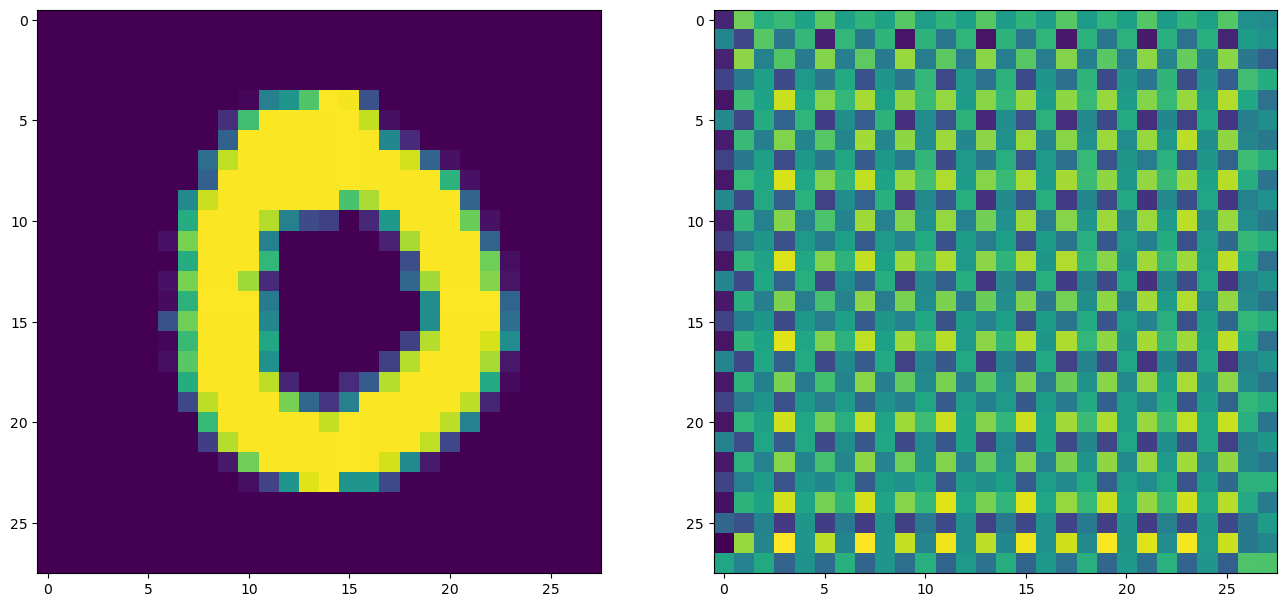

In [32]:
print(len(input_im))
print(len(output_im))
print(input_im[0].shape)

for i in range(10):
    im_x = input_im[0][i].detach().numpy()
    im_y = output_im[0][i].detach().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(im_x.reshape(28, 28))
    
    ax[1].imshow(im_y.reshape(28, 28))

l1_e: torch.Size([4, 14, 14])
activation1: torch.Size([4, 14, 14])
l2_e: torch.Size([16, 7, 7])
activation2: torch.Size([16, 7, 7])
l3_e: torch.Size([64, 5, 5])
activation3: torch.Size([64, 5, 5])
l4_e: torch.Size([256, 3, 3])
activation4: torch.Size([256, 3, 3])
l5_e: torch.Size([1024, 1, 1])
activation5: torch.Size([1024, 1, 1])
l6_d: torch.Size([256, 3, 3])
activation6: torch.Size([256, 3, 3])
l7_d: torch.Size([64, 5, 5])
activation7: torch.Size([64, 5, 5])
l8_d: torch.Size([16, 7, 7])
activation8: torch.Size([16, 7, 7])
l9_e: torch.Size([4, 14, 14])
activation9: torch.Size([4, 14, 14])
l10_e: torch.Size([1, 28, 28])
l1_e: torch.Size([4, 14, 14])
activation1: torch.Size([4, 14, 14])
l2_e: torch.Size([16, 7, 7])
activation2: torch.Size([16, 7, 7])
l3_e: torch.Size([64, 5, 5])
activation3: torch.Size([64, 5, 5])
l4_e: torch.Size([256, 3, 3])
activation4: torch.Size([256, 3, 3])
l5_e: torch.Size([1024, 1, 1])
activation5: torch.Size([1024, 1, 1])
l6_d: torch.Size([256, 3, 3])
activatio

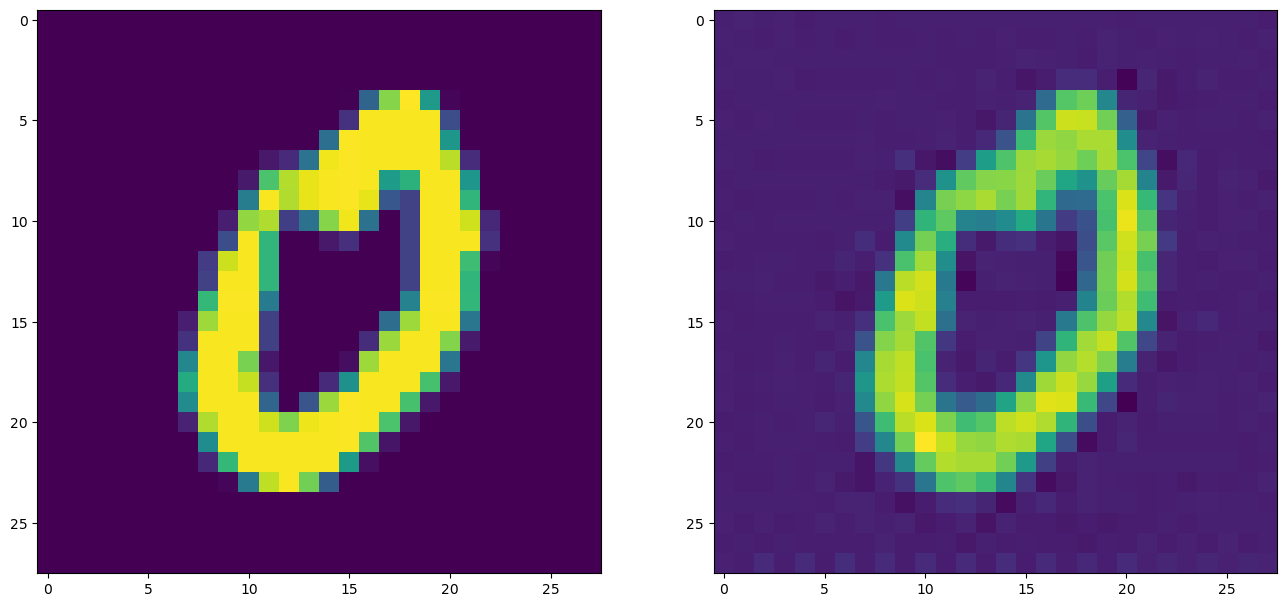

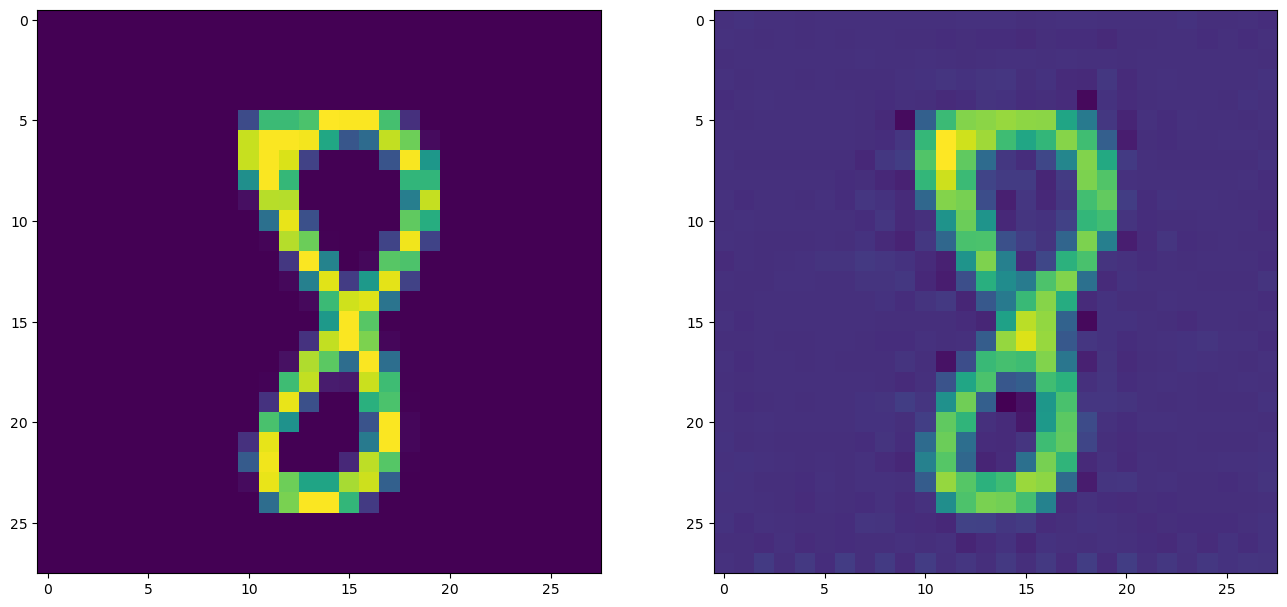

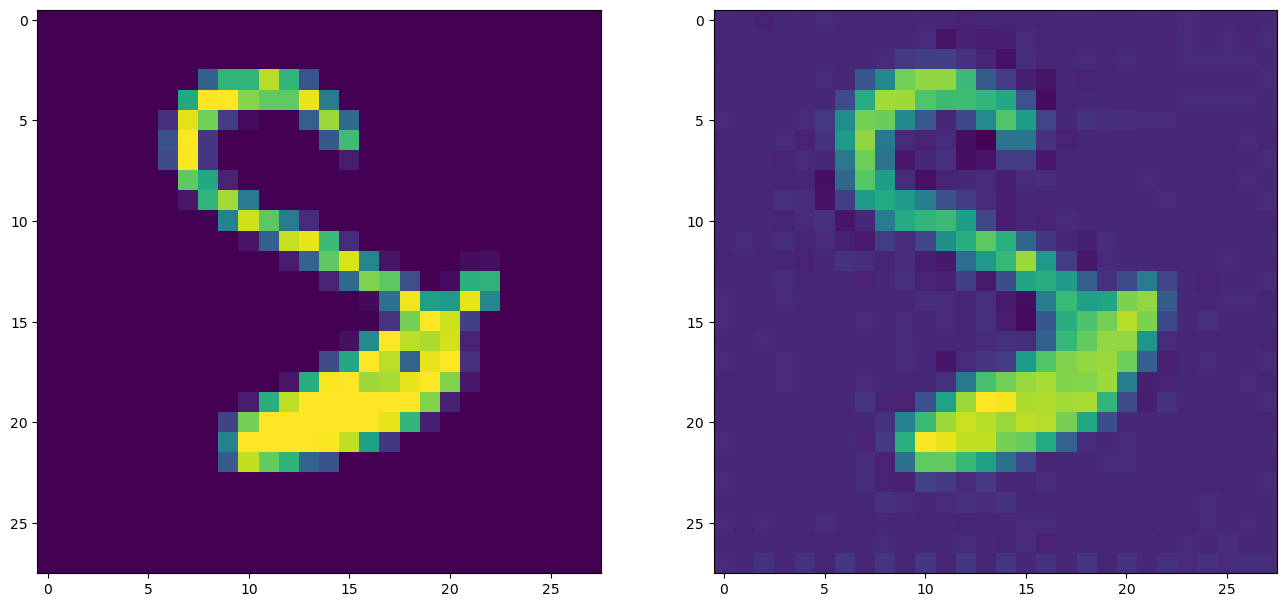

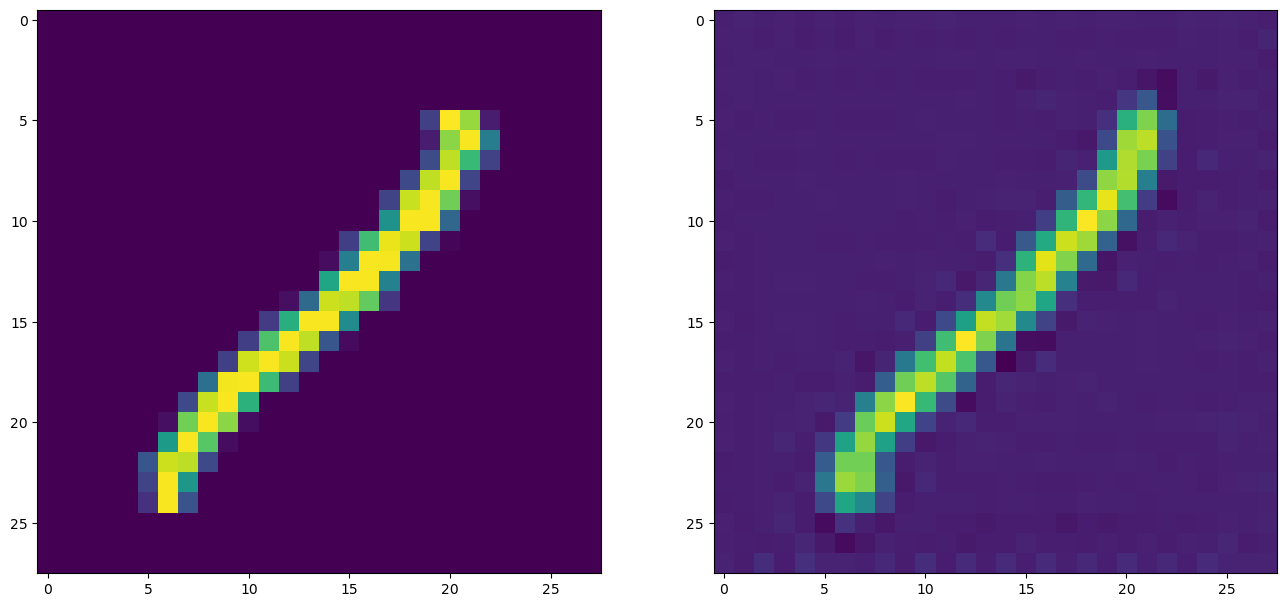

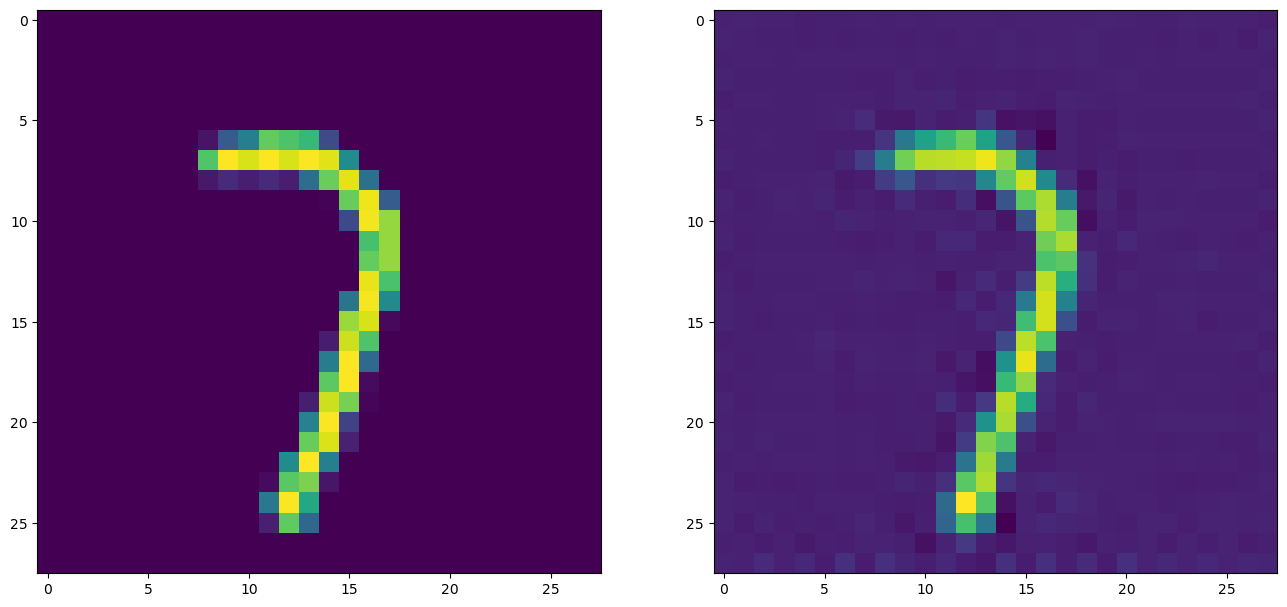

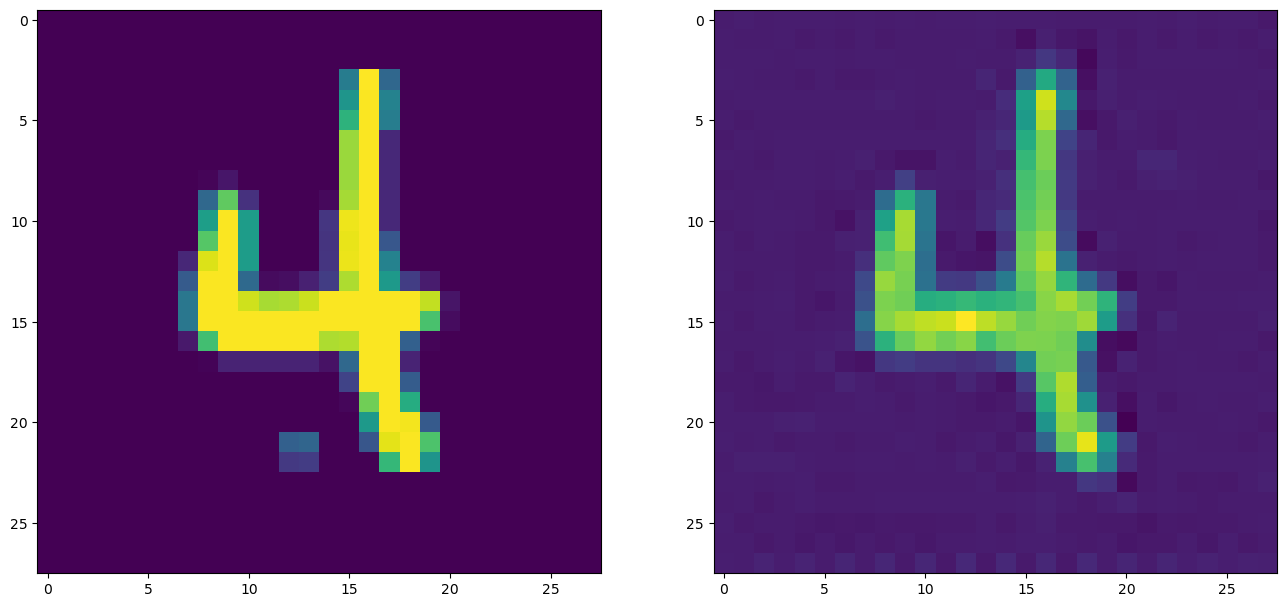

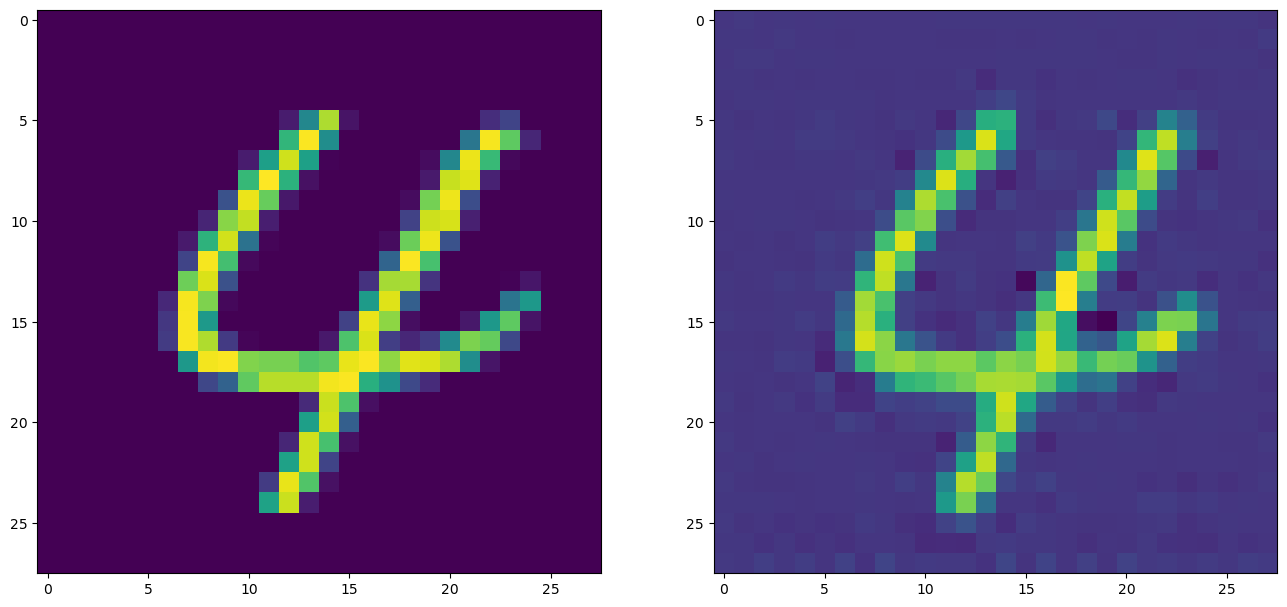

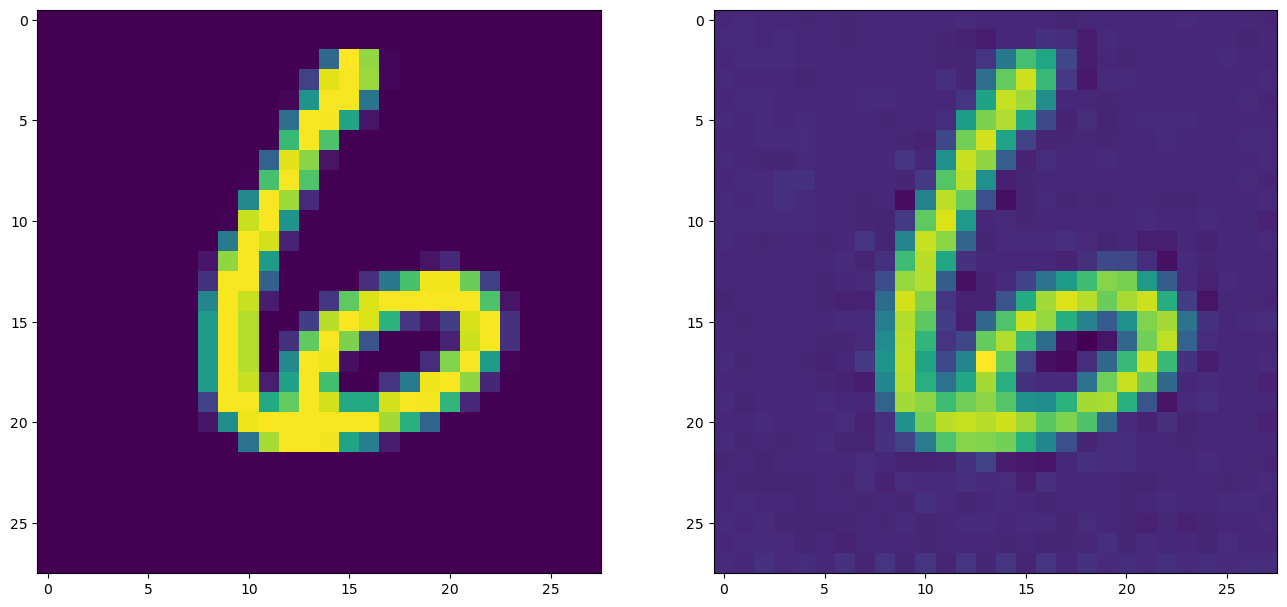

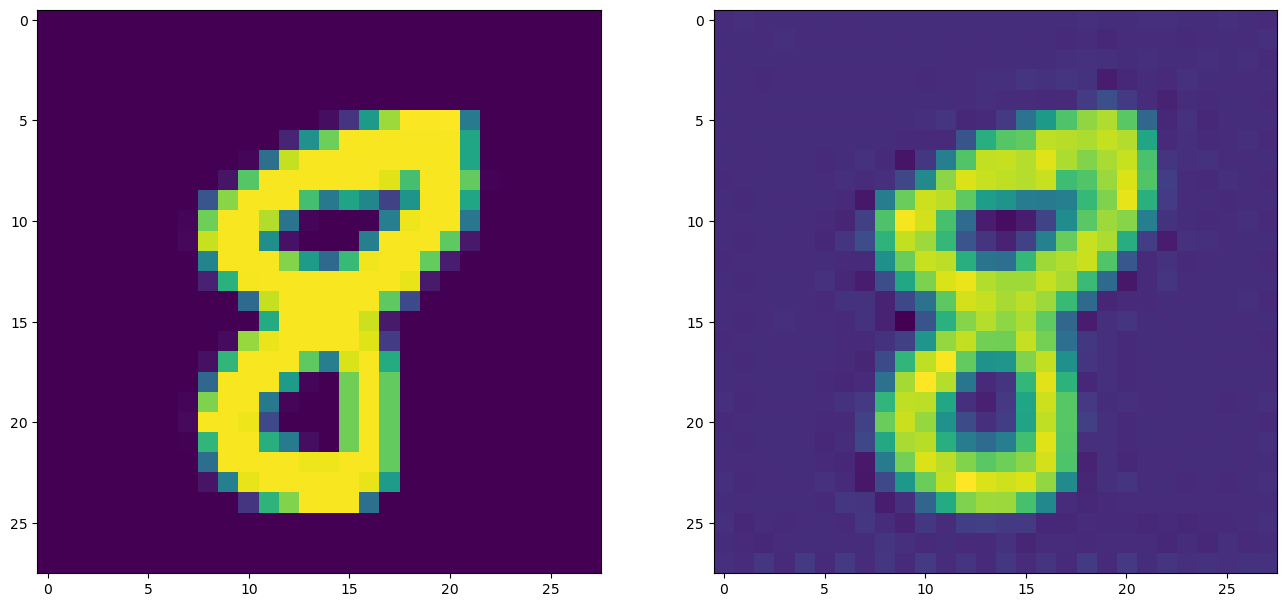

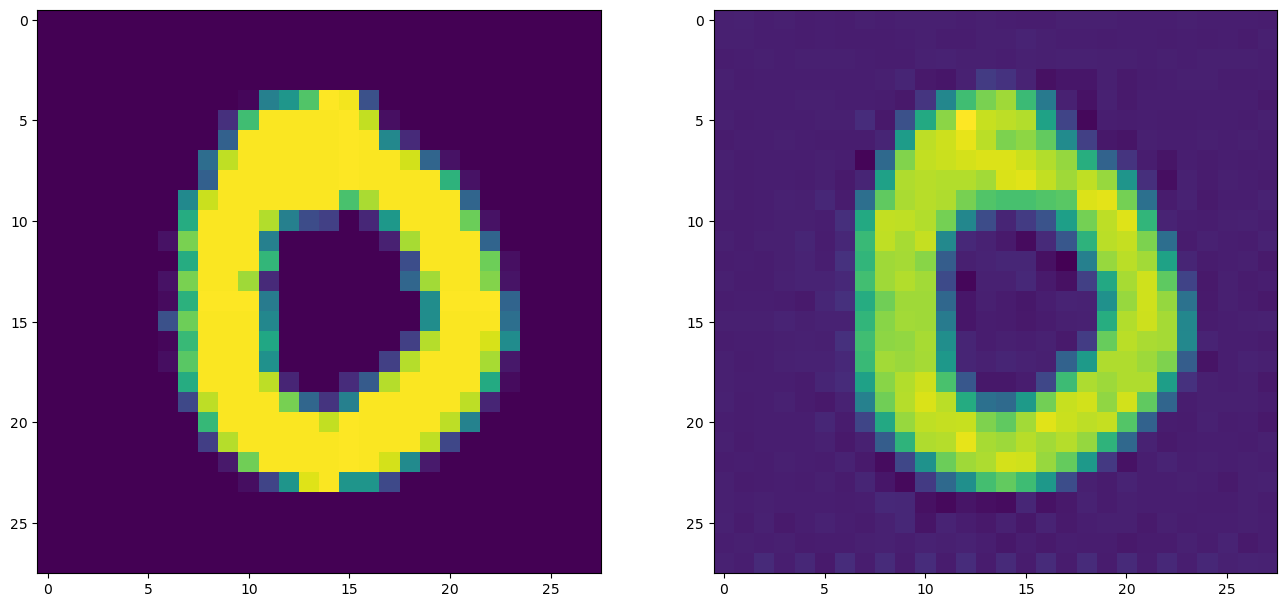

In [33]:
for i in range(10):
    y_pred = model(input_im[0][i])

    im_x = input_im[0][i].detach().numpy()
    im_y = y_pred.detach().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(im_x.reshape(28, 28))
    
    ax[1].imshow(im_y.reshape(28, 28))

In [34]:
from typing import Dict, Iterable, Callable

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    
    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    
    def forward(self, x):
        _ = self.model(x)
        return self._features

In [44]:
resnet_features = FeatureExtractor(model, layers=["l5_e"])
features = resnet_features(_image)

print('\n', (features["l5_e"].detach().numpy())[0][0][0])

l1_e: torch.Size([4, 14, 14])
activation1: torch.Size([4, 14, 14])
l2_e: torch.Size([16, 7, 7])
activation2: torch.Size([16, 7, 7])
l3_e: torch.Size([64, 5, 5])
activation3: torch.Size([64, 5, 5])
l4_e: torch.Size([256, 3, 3])
activation4: torch.Size([256, 3, 3])
l5_e: torch.Size([1024, 1, 1])
activation5: torch.Size([1024, 1, 1])
l6_d: torch.Size([256, 3, 3])
activation6: torch.Size([256, 3, 3])
l7_d: torch.Size([64, 5, 5])
activation7: torch.Size([64, 5, 5])
l8_d: torch.Size([16, 7, 7])
activation8: torch.Size([16, 7, 7])
l9_e: torch.Size([4, 14, 14])
activation9: torch.Size([4, 14, 14])
l10_e: torch.Size([1, 28, 28])

 -0.19926241


In [54]:
eval_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

eval_data_loader = torch.utils.data.DataLoader(
    eval_mnist_data, batch_size=1, shuffle=False, num_workers=2
)

if False:
    data = []
    model.eval()
    with torch.no_grad():
        for batch in eval_data_loader:
            resnet_features = FeatureExtractor(model, layers=["l5_e"])
            features = resnet_features(batch[0])
            data.append(features["l5_e"].detach().numpy())

l1_e: torch.Size([1, 4, 14, 14])
activation1: torch.Size([1, 4, 14, 14])
l2_e: torch.Size([1, 16, 7, 7])
activation2: torch.Size([1, 16, 7, 7])
l3_e: torch.Size([1, 64, 5, 5])
activation3: torch.Size([1, 64, 5, 5])
l4_e: torch.Size([1, 256, 3, 3])
activation4: torch.Size([1, 256, 3, 3])
l5_e: torch.Size([1, 1024, 1, 1])
activation5: torch.Size([1, 1024, 1, 1])
l6_d: torch.Size([1, 256, 3, 3])
activation6: torch.Size([1, 256, 3, 3])
l7_d: torch.Size([1, 64, 5, 5])
activation7: torch.Size([1, 64, 5, 5])
l8_d: torch.Size([1, 16, 7, 7])
activation8: torch.Size([1, 16, 7, 7])
l9_e: torch.Size([1, 4, 14, 14])
activation9: torch.Size([1, 4, 14, 14])
l10_e: torch.Size([1, 1, 28, 28])
l1_e: torch.Size([1, 4, 14, 14])
activation1: torch.Size([1, 4, 14, 14])
l2_e: torch.Size([1, 16, 7, 7])
activation2: torch.Size([1, 16, 7, 7])
l3_e: torch.Size([1, 64, 5, 5])
activation3: torch.Size([1, 64, 5, 5])
l4_e: torch.Size([1, 256, 3, 3])
activation4: torch.Size([1, 256, 3, 3])
l5_e: torch.Size([1, 1024, 

KeyboardInterrupt: 

In [82]:
print(len(data))
print((data)

SyntaxError: unexpected EOF while parsing (1255099068.py, line 2)

In [81]:
data_list = []

for i in data:
    list_num = []
    for j in i[0]:   
        list_num.append(float(j[0][0]))
    data_list.append(list_num)

print(data_list)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
if False:
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in train_data_loader:
            y_predicted = model(batch[0].reshape(-1, 1, 28, 28))
            predicted_labels.append(y_predicted)
            # real_labels.append(batch[1])
    
    predicted_labels = torch.cat(predicted_labels)
# real_labels = torch.cat(real_labels)
# train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()